In [1]:
import time
import torch
import sys
import os
import matplotlib.pyplot as plt

# Add project root to PYTHONPATH
sys.path.append('/home/vkapil/scratch/nl/torch-nlpp')

from ase import Atoms
from pynl import NeighbourList

from vesin import ase_neighbor_list as vesin_ase_neighbor_list
from matscipy.neighbours import neighbour_list as matscipy_neighbour_list
from torch_nl import compute_neighborlist, ase2data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'lines.markersize': 4,
    'lines.linewidth': 1.5,  # Increased from 1 to 1.5
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 8,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.alpha': 1.0,
})

colors = sns.color_palette("deep")

In [3]:
def time_fn(fn, n_tries=10, sync_cuda=False):
    # warmup
    fn()
    if sync_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()

    times = []

    for _ in range(n_tries):
        if sync_cuda and torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.perf_counter()
        fn()
        if sync_cuda and torch.cuda.is_available():
            torch.cuda.synchronize()
        end = time.perf_counter()
        times.append((end - start) * 1000.0)  # ms

    if n_tries == 1:
        return times[0], 0.0

    mean_ms = sum(times) / n_tries

    # sample variance (no math)
    var = sum((t - mean_ms)**2 for t in times) / (n_tries - 1)

    # std and stderr via **0.5 instead of math.sqrt
    std_ms = var ** 0.5
    stderr_ms = std_ms / (n_tries ** 0.5)

    return mean_ms, stderr_ms

In [4]:
cell = [
    [2.460394, 0.0, 0.0],
    [-1.26336, 2.044166, 0.0],
    [-0.139209, -0.407369, 6.809714],
]

positions = [
    [-0.03480225, -0.10184225, 1.70242850],
    [-0.10440675, -0.30552675, 5.10728550],
    [-0.05691216,  1.26093576, 1.70242850],
    [ 1.11473716,  0.37586124, 5.10728550],
]

base = Atoms(
    symbols="CCCC",
    positions=positions,
    cell=cell,
    pbc=True,
) * (4,4,2)


In [5]:

number_of_structures = [1, 2, 4, 8, 16, 32, 64, 128]     
radii = [3.0, 4.5, 6.0]
n_tries = 4

device = "cuda:0" 

In [8]:
number_of_structures = [1, 2, 4, 8, 16, 32, 64, 128]

results = {}   # radius → n_struct → timings dict
base_natoms = len(base)

for radius in radii:
    print("\n" + "=" * 80)
    print(f"radius = {radius}")
    print("=" * 80)

    results[radius] = {}

    for n_struct in number_of_structures:

        # Create n_struct independent copies of the same base structure
        configs = [base.copy() for _ in range(n_struct)]
        total_atoms = n_struct * base_natoms

        print(f"\nNumber of structures: {n_struct}  →  total_atoms = {total_atoms}")

        results[radius][n_struct] = {}

        # --- pynl NeighbourList (O(N^2), no compile) ---
        pynl = NeighbourList(
            list_of_positions=[s.positions for s in configs],
            list_of_cells=[s.cell.array for s in configs],
            cutoff=radius,
            batch_size=n_struct,
            device=device,
        )
        pynl.load_data()

        def pynl_no_compile():
            _ = pynl.calculate_neighbourlist(use_torch_compile=False)

        t_pynl_no_compile, e_pynl_no_compile = time_fn(
            pynl_no_compile, n_tries=n_tries, sync_cuda=True
        )
        results[radius][n_struct]["pynl_on2"] = {
            "mean": t_pynl_no_compile,
            "stderr": e_pynl_no_compile,
        }

        # --- pynl NeighbourList (O(N^2), compile=True) ---
        def pynl_compile():
            _ = pynl.calculate_neighbourlist(use_torch_compile=True)

        t_pynl_compile, e_pynl_compile = time_fn(
            pynl_compile, n_tries=n_tries, sync_cuda=True
        )
        results[radius][n_struct]["pynl_on2_compile"] = {
            "mean": t_pynl_compile,
            "stderr": e_pynl_compile,
        }

        # --- VESIN neighbour list (O(N)) ---
        def vesin_nl():
            for atoms in configs:
                i, j, S, D, d = vesin_ase_neighbor_list("ijSDd", atoms, cutoff=radius)

        t_vesin, e_vesin = time_fn(vesin_nl, n_tries=n_tries, sync_cuda=False)
        results[radius][n_struct]["vesin_on1"] = {
            "mean": t_vesin,
            "stderr": e_vesin,
        }

        # --- matscipy neighbour list (O(N)) ---
        def matscipy_nl():
            for atoms in configs:
                i, j, S, D, d = matscipy_neighbour_list("ijSDd", atoms, cutoff=radius)

        t_matscipy, e_matscipy = time_fn(
            matscipy_nl, n_tries=n_tries, sync_cuda=False
        )
        results[radius][n_struct]["matscipy_on1"] = {
            "mean": t_matscipy,
            "stderr": e_matscipy,
        }

        # --- torch-nl O(N) fully batched ---
        pos, cell_t, pbc, batch, _ = ase2data(configs)

        def torch_nl_n1():
            compute_neighborlist(radius, pos, cell_t, pbc, batch, False)

        t_torch_n1, e_torch_n1 = time_fn(
            torch_nl_n1, n_tries=n_tries, sync_cuda=True
        )
        results[radius][n_struct]["torch_on1"] = {
            "mean": t_torch_n1,
            "stderr": e_torch_n1,
        }

        # summary
        print(
            f"  pynl O(N^2) (no compile)   : "
            f"{t_pynl_no_compile:8.3f} ± {e_pynl_no_compile:5.3f} ms"
        )
        print(
            f"  pynl O(N^2) (compile)      : "
            f"{t_pynl_compile:8.3f} ± {e_pynl_compile:5.3f} ms"
        )
        print(
            f"  VESIN O(N)                 : "
            f"{t_vesin:8.3f} ± {e_vesin:5.3f} ms"
        )
        print(
            f"  matscipy O(N)              : "
            f"{t_matscipy:8.3f} ± {e_matscipy:5.3f} ms"
        )
        print(
            f"  torch-nl O(N)              : "
            f"{t_torch_n1:8.3f} ± {e_torch_n1:5.3f} ms"
        )



radius = 3.0

Number of structures: 1  →  total_atoms = 128


/home/vkapil/anaconda3/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


  pynl O(N^2) (no compile)   :    0.719 ± 0.110 ms
  pynl O(N^2) (compile)      :    0.738 ± 0.093 ms
  VESIN O(N)                 :    0.292 ± 0.010 ms
  matscipy O(N)              :    0.501 ± 0.007 ms
  torch-nl O(N)              :    8.357 ± 4.691 ms

Number of structures: 2  →  total_atoms = 256
  pynl O(N^2) (no compile)   :    0.832 ± 0.051 ms
  pynl O(N^2) (compile)      :    0.896 ± 0.090 ms
  VESIN O(N)                 :    0.497 ± 0.016 ms
  matscipy O(N)              :    0.915 ± 0.008 ms
  torch-nl O(N)              :    5.332 ± 0.190 ms

Number of structures: 4  →  total_atoms = 512
  pynl O(N^2) (no compile)   :    1.039 ± 0.044 ms
  pynl O(N^2) (compile)      :    0.924 ± 0.007 ms
  VESIN O(N)                 :    0.927 ± 0.016 ms
  matscipy O(N)              :    1.639 ± 0.007 ms
  torch-nl O(N)              :   10.012 ± 0.154 ms

Number of structures: 8  →  total_atoms = 1024
  pynl O(N^2) (no compile)   :    1.553 ± 0.021 ms
  pynl O(N^2) (compile)      :    1.292 ± 

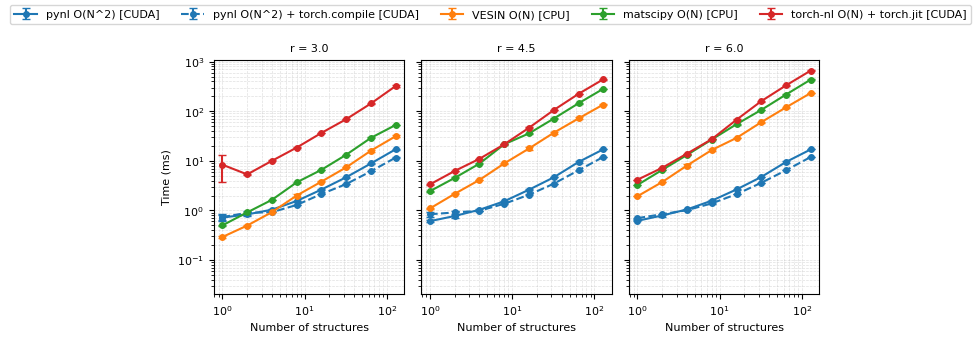

In [9]:
methods = [
    "pynl_on2",
    "pynl_on2_compile",
    "vesin_on1",
    "matscipy_on1",
    "torch_on1",
]

labels = {
    "pynl_on2":         "pynl O(N^2) [CUDA]",
    "pynl_on2_compile": "pynl O(N^2) + torch.compile [CUDA]",
    "vesin_on1":        "VESIN O(N) [CPU]",
    "matscipy_on1":     "matscipy O(N) [CPU]",
    "torch_on1":        "torch-nl O(N) + torch.jit [CUDA]",
}

# One color per method family (pynl_on2 + pynl_on2_compile share color)
colors = {
    "pynl_on2":     "tab:blue",
    "vesin_on1":    "tab:orange",
    "matscipy_on1": "tab:green",
    "torch_on1":    "tab:red",
}

radii_list = list(results.keys())
num_panels = len(radii_list)

fig, axes = plt.subplots(
    1,
    num_panels,
    sharex=True,
    sharey=True,
    figsize=(3.41 * 2, 3.41),
)

if num_panels == 1:
    axes = [axes]

for ax, radius in zip(axes, radii_list):

    # x-axis = number of structures
    n_struct_list = sorted(results[radius].keys())

    for method in methods:

        means  = [results[radius][n][method]["mean"]   for n in n_struct_list]
        errors = [results[radius][n][method]["stderr"] for n in n_struct_list]

        # Color by family: pynl_on2 + pynl_on2_compile → "pynl_on2"
        if method.startswith("pynl_on2"):
            color_key = "pynl_on2"
        else:
            color_key = method

        color = colors[color_key]
        linestyle = "--" if "compile" in method else "-"

        ax.errorbar(
            n_struct_list,
            means,
            yerr=errors,
            marker="o",
            linestyle=linestyle,
            color=color,
            capsize=3,
            label=labels[method],
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"r = {radius}")
    ax.grid(True, which="both", ls="--", alpha=0.4)

for ax in axes:
    ax.set_xlabel("Number of structures")
axes[0].set_ylabel("Time (ms)")

handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc="upper center", ncol=len(methods))

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
